<div style="border-left: 5px solid rgb(134, 231, 134); background-color: rgba(61, 117, 61, 0.1); padding: 10px; color: rgb(230, 230, 230);">
    <span style="color:rgb(134, 231, 134); font-size: 1.5em;">Compte rendu de Noé Mosca</span>  
</div>

# On charge les features des données d'entraînement.

In [115]:
import os
import nibabel as nib
import numpy as np
import pandas as pd

# === Chemins ===
DATA_DIR = "Train"
CSV_PATH = "metaDataTrain.csv"
OUTPUT_CSV = "features.csv"

# === Fonctions utilitaires ===
def load_mask(path):
    nii = nib.load(path)
    data = nii.get_fdata()
    spacing = nii.header.get_zooms()[:3]
    return data, spacing

def compute_volume(mask, label, spacing):
    voxel_volume = np.prod(spacing)  # mm³
    count = np.sum(mask == label)
    return count * voxel_volume / 1000  # en mL

def compute_mass(mask, spacing):
    volume = compute_volume(mask, label=2, spacing=spacing)  # myocarde
    return volume * 1.05  # masse myocardique en grammes

def compute_ef(ed_vol, es_vol):
    return 100 * (ed_vol - es_vol) / ed_vol if ed_vol else 0

def compute_bsa_mosteller(weight, height):
    return np.sqrt((weight * height) / 3600)

# === Chargement des métadonnées ===
meta_df = pd.read_csv(CSV_PATH)
meta_df["Id"] = meta_df["Id"].apply(lambda x: str(x).zfill(3))
meta_df = meta_df.set_index("Id")

# === Liste des patients ===
patients = [p for p in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, p))]

all_features = []

for pid in sorted(patients):
    print(f"🔍 Processing patient {pid}")
    try:
        prefix = pid

        # Chemins vers les masques segmentés
        ed_seg_path = os.path.join(DATA_DIR, pid, f"{prefix}_ED_seg.nii")
        es_seg_path = os.path.join(DATA_DIR, pid, f"{prefix}_ES_seg.nii")

        ed_mask, spacing = load_mask(ed_seg_path)
        es_mask, _ = load_mask(es_seg_path)

        # Volumes
        ed_vg = compute_volume(ed_mask, label=3, spacing=spacing)
        es_vg = compute_volume(es_mask, label=3, spacing=spacing)
        ed_rv = compute_volume(ed_mask, label=1, spacing=spacing)
        es_rv = compute_volume(es_mask, label=1, spacing=spacing)

        # Masse myocardique
        mass_ed = compute_mass(ed_mask, spacing)
        mass_es = compute_mass(es_mask, spacing)
        mass_avg = (mass_ed + mass_es) / 2

        # EF VG et RV
        ef = compute_ef(ed_vg, es_vg)
        rv_ef = compute_ef(ed_rv, es_rv)

        # Métadonnées
        weight = meta_df.loc[pid]["Weight"]
        height = meta_df.loc[pid]["Height"]
        category = meta_df.loc[pid]["Category"]
        bsa = compute_bsa_mosteller(weight, height)

        # Features dérivés
        stroke_volume = ed_vg - es_vg
        lv_mass_index = mass_avg / bsa
        es_vg_index = es_vg / bsa
        ed_rv_index = ed_rv / bsa
        ratio_rv_vg_es = es_rv / es_vg if es_vg else 0
        ratio_rv_vg_ed = ed_rv / ed_vg if ed_vg else 0

        # === Nouveaux biomarqueurs ===
        ed_vg_index = ed_vg / bsa if bsa else 0
        es_rv_index = es_rv / bsa if bsa else 0
        myocardium_to_vg_ed = mass_ed / ed_vg if ed_vg else 0
        mass_to_edv_ratio = mass_avg / ed_vg if ed_vg else 0
        mass_ratio_systole_diastole = mass_es / mass_ed if mass_ed else 0

        features = {
            "patient_id": pid,
            "category": category,
            "ed_vg_vol": ed_vg,
            "es_vg_vol": es_vg,
            "ef": ef,
            "ed_rv_vol": ed_rv,
            "es_rv_vol": es_rv,
            "rv_ef": rv_ef,
            "myocardium_mass": mass_avg,
            "lv_mass_index": lv_mass_index,
            "stroke_volume": stroke_volume,
            "es_vg_index": es_vg_index,
            "ed_rv_index": ed_rv_index,
            "ratio_rv_vg_es": ratio_rv_vg_es,
            "ratio_rv_vg_ed": ratio_rv_vg_ed,
            "weight": weight,
            "height": height,
            "bsa": bsa,
            "ed_vg_index": ed_vg_index,
            "es_rv_index": es_rv_index,
            "myocardium_to_vg_ed": myocardium_to_vg_ed,
            "mass_to_edv_ratio": mass_to_edv_ratio,
            "mass_ratio_systole_diastole": mass_ratio_systole_diastole
        }

        all_features.append(features)

    except Exception as e:
        print(f"❌ Erreur pour {pid} : {e}")

# === Export final
df = pd.DataFrame(all_features)
df.to_csv(OUTPUT_CSV, index=False)
print(f"\n✅ Fichier de features enrichi enregistré : {OUTPUT_CSV}")

🔍 Processing patient 001
🔍 Processing patient 002
🔍 Processing patient 003
🔍 Processing patient 004
🔍 Processing patient 005
🔍 Processing patient 006
🔍 Processing patient 007
🔍 Processing patient 008
🔍 Processing patient 009
🔍 Processing patient 010
🔍 Processing patient 011
🔍 Processing patient 012
🔍 Processing patient 013
🔍 Processing patient 014
🔍 Processing patient 015
🔍 Processing patient 016
🔍 Processing patient 017
🔍 Processing patient 018
🔍 Processing patient 019
🔍 Processing patient 020
🔍 Processing patient 021
🔍 Processing patient 022
🔍 Processing patient 023
🔍 Processing patient 024
🔍 Processing patient 025
🔍 Processing patient 026
🔍 Processing patient 027
🔍 Processing patient 028
🔍 Processing patient 029
🔍 Processing patient 030
🔍 Processing patient 031
🔍 Processing patient 032
🔍 Processing patient 033
🔍 Processing patient 034
🔍 Processing patient 035
🔍 Processing patient 036
🔍 Processing patient 037
🔍 Processing patient 038
🔍 Processing patient 039
🔍 Processing patient 040


# Visualisation des features

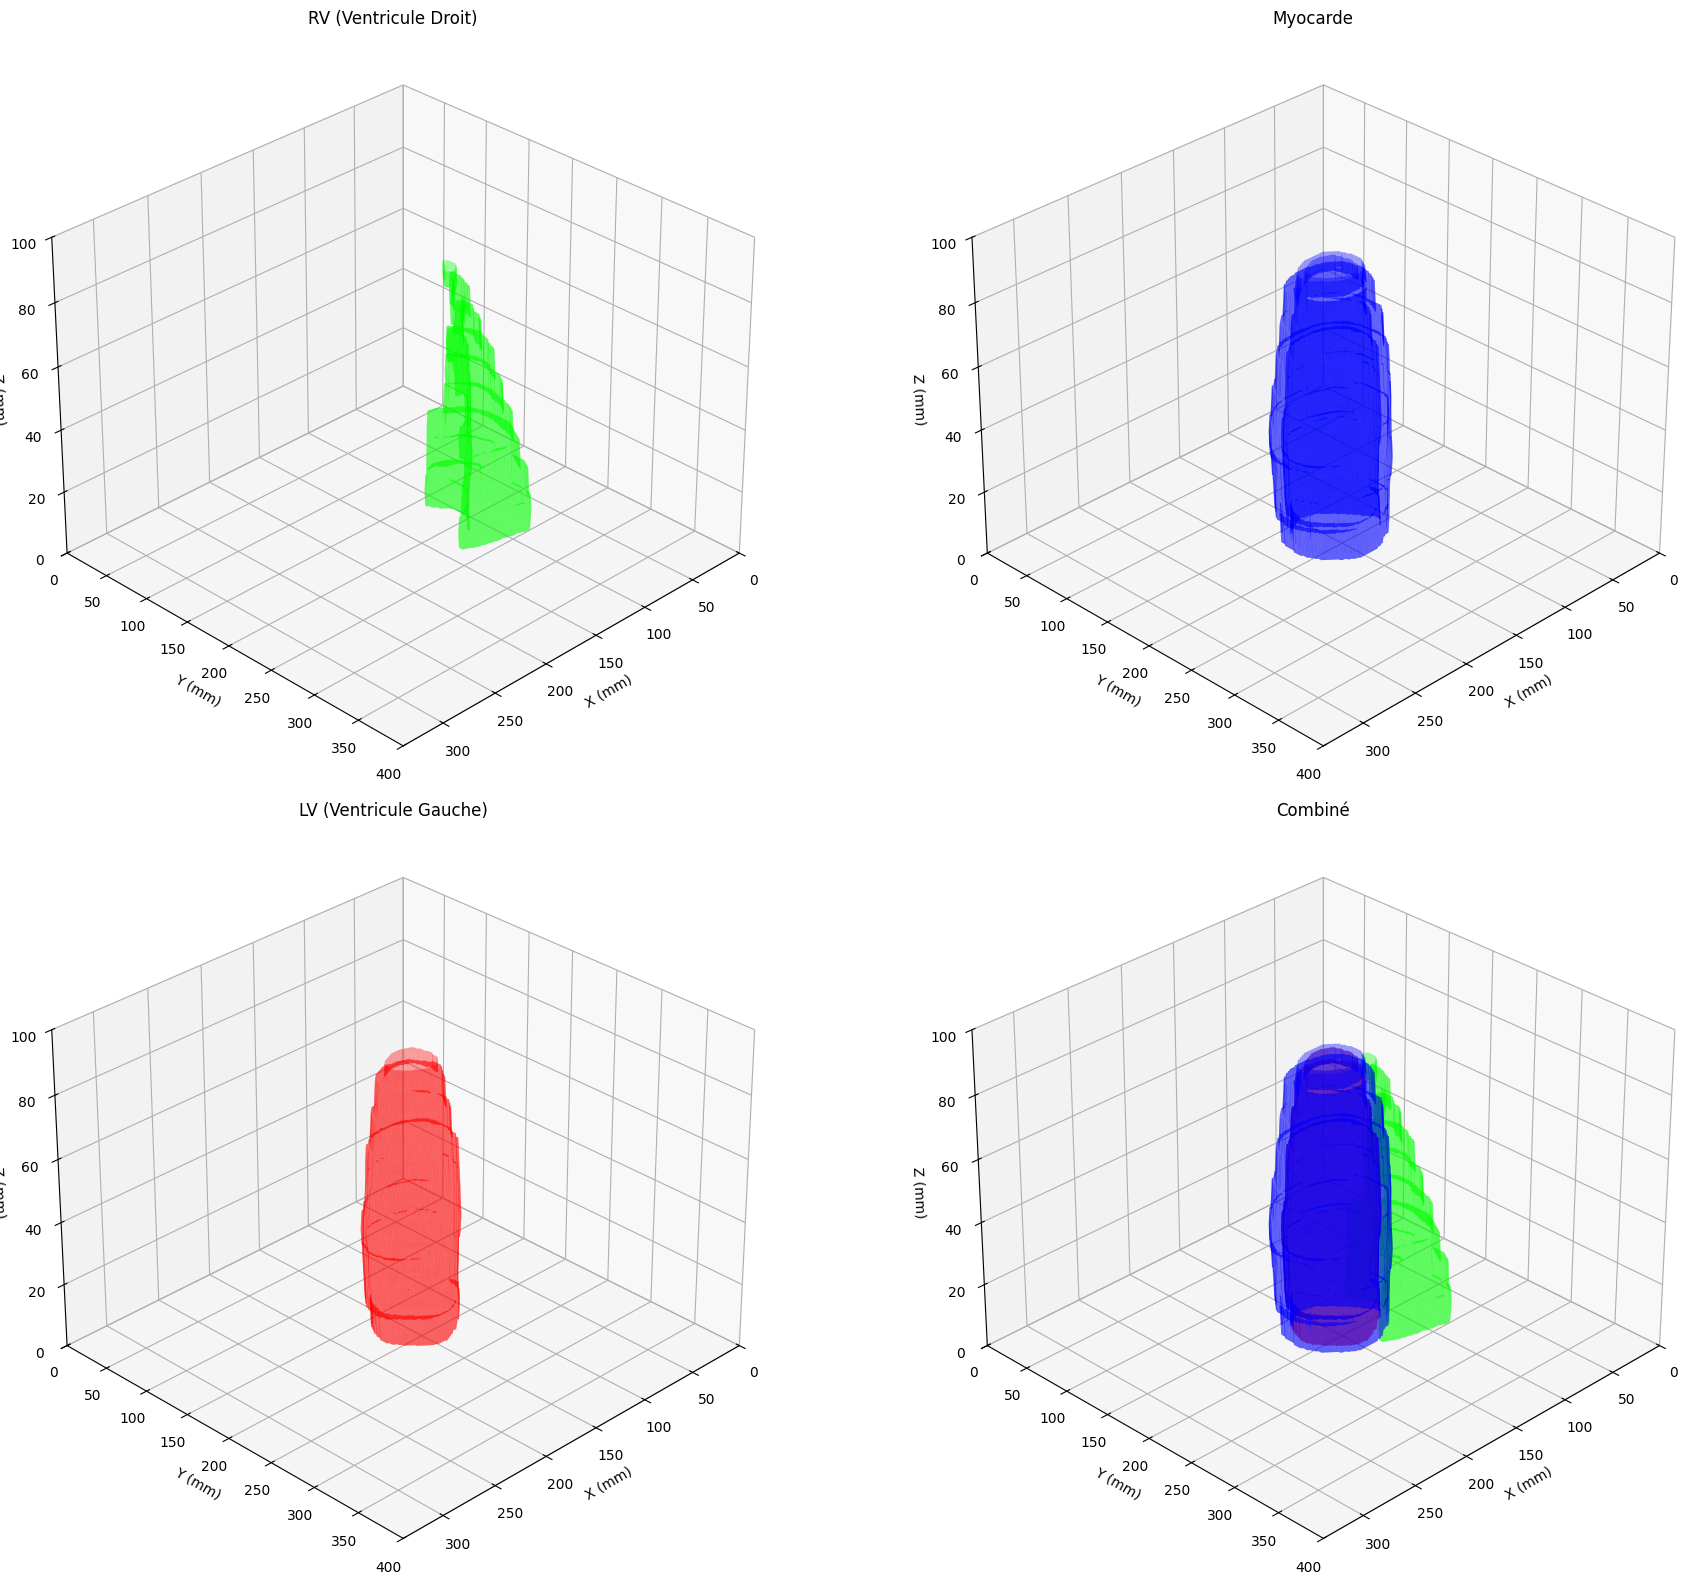

In [158]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

def plot_heart_subplots(seg_file_path):
    # Charger le fichier NIfTI
    nii = nib.load(seg_file_path)
    seg_data = nii.get_fdata()
    voxel_size = nii.header.get_zooms()[:3]

    # Couleurs pour chaque structure
    colors = {
        1: (0, 1, 0, 0.4),   # RV - Vert
        2: (0, 0, 1, 0.4),   # Myocarde - Bleu
        3: (1, 0, 0, 0.4)    # LV - Rouge
    }

    labels = [1, 2, 3, "all"]
    titles = ["RV (Ventricule Droit)", "Myocarde", "LV (Ventricule Gauche)", "Combiné"]

    fig = plt.figure(figsize=(20, 16))

    for i, label in enumerate(labels):
        ax = fig.add_subplot(2, 2, i + 1, projection='3d')

        if label == "all":
            to_plot = [1, 2, 3]
        else:
            to_plot = [label]

        for struct_id in to_plot:
            mask = seg_data == struct_id
            if np.sum(mask) == 0:
                continue

            verts, faces, _, _ = measure.marching_cubes(mask, level=0.5, spacing=voxel_size)

            mesh = Poly3DCollection(verts[faces], alpha=colors[struct_id][3])
            mesh.set_facecolor(colors[struct_id][:3])
            mesh.set_edgecolor('none')
            ax.add_collection3d(mesh)

        ax.set_xlabel('X (mm)')
        ax.set_ylabel('Y (mm)')
        ax.set_zlabel('Z (mm)')
        ax.set_title(titles[i])
        ax.view_init(elev=30, azim=45)

        # Ajuster les limites
        max_dim = np.array(seg_data.shape) * voxel_size
        ax.set_xlim(0, max_dim[0])
        ax.set_ylim(0, max_dim[1])
        ax.set_zlim(0, max_dim[2])

    plt.tight_layout()
    plt.show()

# === Exemple d'utilisation ===
seg_file = "Train/001/001_ED_seg.nii"
plot_heart_subplots(seg_file)

# Grid-search pour les paramètres des MLPs

#### On traivaille ici avec une méthode ensemble : on combine plusieurs MLPs dont on fait la mouyenne avec un autre classifieur faible qu'on dertimenra par la suite. Le but est donc dans un premier temps de déterminer quels sont les meilleurs paramètres pour notre MLP.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from itertools import product
import joblib

# Chargement des données
df = pd.read_csv("features.csv")
patient_ids = df["patient_id"].values
X = df.drop(columns=["patient_id", "category"]).values
y = df["category"].values

X, y, patient_ids = shuffle(X, y, patient_ids, random_state=42)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

n_features = X.shape[1]
n_classes = len(np.unique(y))

# MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# === Grid Search Parameters ===
epochs_list = [100, 200, 500]
lr_list = [1e-3, 5e-4, 1e-4]
batch_size_list = [30, 60]
subset_pct_list = [0.75, 0.9]

results = []

for epochs, lr, batch_size, subset_pct in product(epochs_list, lr_list, batch_size_list, subset_pct_list):
    print(f"\n Test config → epochs={epochs}, lr={lr}, batch_size={batch_size}, subset_pct={subset_pct}")

    mlp_accuracies = []

    for i in range(10):  # 10 MLPs pour tester rapidement
        idx_patients = np.random.choice(len(X_tensor), int(subset_pct * len(X_tensor)), replace=False)
        idx_features = np.sort(np.random.choice(n_features, int(2 * n_features / 3), replace=False))

        X_sub = X_tensor[idx_patients][:, idx_features]
        y_sub = y_tensor[idx_patients]

        train_dataset = TensorDataset(X_sub, y_sub)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        model = MLP(input_dim=len(idx_features), output_dim=n_classes)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        model.train()
        for epoch in range(epochs):
            for xb, yb in train_loader:
                out = model(xb)
                loss = criterion(out, yb)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Evaluation sur le sous-échantillon
        model.eval()
        with torch.no_grad():
            preds = model(X_sub)
            preds_classes = torch.argmax(preds, dim=1)
            acc = accuracy_score(y_sub.numpy(), preds_classes.numpy())
            mlp_accuracies.append(acc)

    avg_acc = np.mean(mlp_accuracies)
    results.append({
        "epochs": epochs,
        "lr": lr,
        "batch_size": batch_size,
        "subset_pct": subset_pct,
        "accuracy": avg_acc
    })

    print(f" Moyenne Accuracy sur 10 MLP : {avg_acc:.4f}")

# === Affichage des meilleurs résultats
results_sorted = sorted(results, key=lambda x: x["accuracy"], reverse=True)

print("\n=== Meilleurs paramètres ===")
for res in results_sorted[:5]:
    print(res)



🚀 Test config → epochs=100, lr=0.001, batch_size=30, subset_pct=0.75
✅ Moyenne Accuracy sur 10 MLP : 1.0000

🚀 Test config → epochs=100, lr=0.001, batch_size=30, subset_pct=0.9
✅ Moyenne Accuracy sur 10 MLP : 1.0000

🚀 Test config → epochs=100, lr=0.001, batch_size=60, subset_pct=0.75
✅ Moyenne Accuracy sur 10 MLP : 1.0000

🚀 Test config → epochs=100, lr=0.001, batch_size=60, subset_pct=0.9
✅ Moyenne Accuracy sur 10 MLP : 1.0000

🚀 Test config → epochs=100, lr=0.0005, batch_size=30, subset_pct=0.75
✅ Moyenne Accuracy sur 10 MLP : 0.9973

🚀 Test config → epochs=100, lr=0.0005, batch_size=30, subset_pct=0.9
✅ Moyenne Accuracy sur 10 MLP : 0.9989

🚀 Test config → epochs=100, lr=0.0005, batch_size=60, subset_pct=0.75
✅ Moyenne Accuracy sur 10 MLP : 0.9840

🚀 Test config → epochs=100, lr=0.0005, batch_size=60, subset_pct=0.9
✅ Moyenne Accuracy sur 10 MLP : 0.9989

🚀 Test config → epochs=100, lr=0.0001, batch_size=30, subset_pct=0.75
✅ Moyenne Accuracy sur 10 MLP : 0.8880

🚀 Test config → e

# Cross-validation avec les meilleurs paramètres

### On applique les paramètres obtenus précédement à nos MLP et on teste leur accuracy par validation croisée.

Fold 1 Accuracy (Ensemble MLP): 0.9000
Fold 2 Accuracy (Ensemble MLP): 0.9500
Fold 3 Accuracy (Ensemble MLP): 1.0000
Fold 4 Accuracy (Ensemble MLP): 0.8000
Fold 5 Accuracy (Ensemble MLP): 1.0000

Cross-validation terminée - Accuracy moyenne (Ensemble MLP): 0.9300


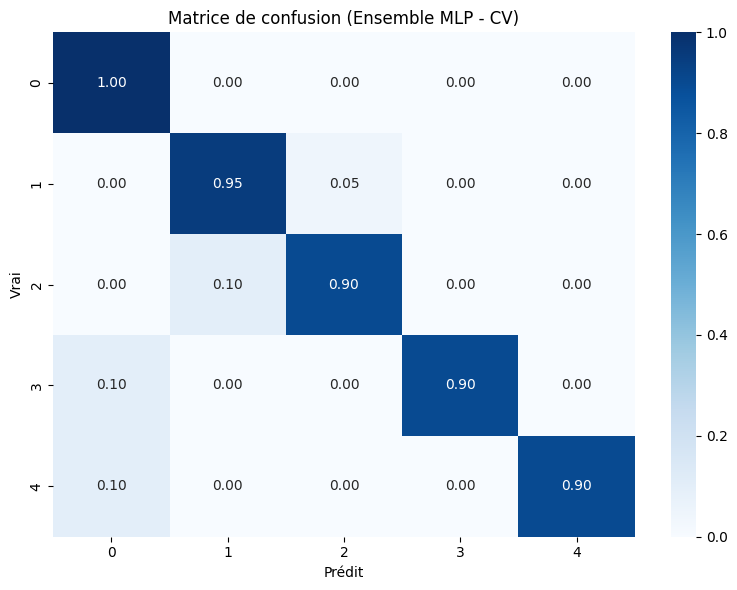


✅ Ensemble des 50 MLP sauvegardé pour l'inférence → mlp_ensemble.pkl


In [117]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# === Prépare X_tensor, y_tensor, n_classes, n_features, MLP, etc. en amont ===

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# === Wrapper Ensemble pour moyenne + prédiction plus tard ===
class MLPEnsemble:
    def __init__(self, models_feats, n_classes):
        self.models_feats = models_feats  # Liste de tuples (model, feats)
        self.n_classes = n_classes
        self.softmax = torch.nn.Softmax(dim=1)

    def predict_proba(self, X_tensor):
        avg_probs = np.zeros((len(X_tensor), self.n_classes), dtype=np.float32)
        for model, feats in self.models_feats:
            model.eval()
            with torch.no_grad():
                logits = model(X_tensor[:, feats])
                probs = self.softmax(logits).cpu().numpy()
                avg_probs += probs
        avg_probs /= len(self.models_feats)
        return avg_probs

    def predict(self, X_tensor):
        probs = self.predict_proba(X_tensor)
        return np.argmax(probs, axis=1)

# Containers
mlp_probs_cv = np.zeros((len(X_tensor), n_classes), dtype=np.float32)
mlp_preds_cv = np.zeros(len(X_tensor), dtype=np.int64)

kfold      = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_acc   = []
all_preds  = []
all_true   = []

n_epochs   = 200
batch_size = 30
n_mlps     = 50

mlp_ensemble_all = []  # <== ICI on stocke tous les modèles pour sauvegarde plus tard

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_tensor, y_tensor)):
    X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
    y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

    val_preds_ensemble = []
    mlp_ensemble = []  # <== les 50 MLP de CE fold

    for model_num in range(n_mlps):
        idx_patients = np.random.choice(len(X_train), int(0.75 * len(X_train)), replace=False)
        idx_features = np.sort(np.random.choice(n_features, int(2 * n_features / 3), replace=False))

        X_sub = X_train[idx_patients][:, idx_features]
        y_sub = y_train[idx_patients]

        ds = TensorDataset(X_sub, y_sub)
        loader = DataLoader(ds, batch_size=batch_size, shuffle=True)

        model = MLP(input_dim=len(idx_features), output_dim=n_classes)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        model.train()
        for _ in range(n_epochs):
            for xb, yb in loader:
                out = model(xb)
                loss = criterion(out, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            logits = model(X_val[:, idx_features])
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            val_preds_ensemble.append(probs)

        # Sauvegarder le modèle + ses features
        mlp_ensemble.append((model.cpu(), idx_features))

    # Moyenne des probabilités des 50 MLP
    val_preds_ensemble = np.stack(val_preds_ensemble, axis=0)
    val_preds_mean     = val_preds_ensemble.mean(axis=0)
    val_preds_classes  = np.argmax(val_preds_mean, axis=1)

    mlp_probs_cv[val_idx] = val_preds_mean
    mlp_preds_cv[val_idx] = val_preds_classes

    acc = accuracy_score(y_val.numpy(), val_preds_classes)
    fold_acc.append(acc)
    print(f"Fold {fold+1} Accuracy (Ensemble MLP): {acc:.4f}")

    all_preds.extend(val_preds_classes.tolist())
    all_true.extend(y_val.numpy().tolist())

    # Ajouter ce fold dans l'ensemble global
    mlp_ensemble_all.extend(mlp_ensemble)

# Accuracy finale
avg_acc = np.mean(fold_acc)
print(f"\nCross-validation terminée - Accuracy moyenne (Ensemble MLP): {avg_acc:.4f}")

# Matrice de confusion globale
conf_mat = confusion_matrix(all_true, all_preds)
conf_mat_norm = conf_mat.astype(float) / conf_mat.sum(axis=1)[:, None]

plt.figure(figsize=(8,6))
sns.heatmap(conf_mat_norm, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=np.arange(n_classes),
            yticklabels=np.arange(n_classes))
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion (Ensemble MLP - CV)")
plt.tight_layout()
plt.show()

# === SAUVEGARDE DE L'ENSEMBLE ===
ensemble_model = MLPEnsemble(models_feats=mlp_ensemble_all, n_classes=n_classes)
joblib.dump(ensemble_model, "mlp_ensemble.pkl")
print("\n✅ Ensemble des 50 MLP sauvegardé pour l'inférence → mlp_ensemble.pkl")

# On sauvegarde ensuite le résultat comme moyenne des 50 MLPs obtenus.

In [135]:
mlp_probs = np.zeros((len(X_tensor), n_classes))
softmax = torch.nn.Softmax(dim=1)

for model, feats in mlp_ensemble.models_feats:
    with torch.no_grad():
        logits = model(X_tensor[:, feats])
        probs = softmax(logits).numpy()
        mlp_probs += probs

mlp_probs /= len(mlp_ensemble.models_feats)

# Random Forest
### Le 2e classifier qui peut être combiné aux MLPs peut-être un Random Forest. Dans un premier temps on détermine les paramètres optimaux.

In [120]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
from itertools import product

# Paramètres du grid search
n_estimators_list = [50, 100, 200,300, 500]
max_depth_list = [None, 10, 20]
max_features_list = ["sqrt", "log2"]

# Stocker les résultats
results = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for n_estimators, max_depth, max_features in product(n_estimators_list, max_depth_list, max_features_list):
    print(f"\nTest config → n_estimators={n_estimators}, max_depth={max_depth}, max_features={max_features}")
    fold_acc = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            random_state=42
        )
        rf.fit(X_train, y_train)
        val_preds = rf.predict(X_val)

        acc = accuracy_score(y_val, val_preds)
        fold_acc.append(acc)

    avg_acc = np.mean(fold_acc)
    results.append({
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "max_features": max_features,
        "accuracy": avg_acc
    })
    
    print(f"→ Accuracy moyenne : {avg_acc:.4f}")

# === Résultats triés
results_sorted = sorted(results, key=lambda x: x["accuracy"], reverse=True)

print("\n=== Meilleurs paramètres ===")
for res in results_sorted[:5]:
    print(res)


Test config → n_estimators=50, max_depth=None, max_features=sqrt
→ Accuracy moyenne : 0.9400

Test config → n_estimators=50, max_depth=None, max_features=log2
→ Accuracy moyenne : 0.9400

Test config → n_estimators=50, max_depth=10, max_features=sqrt
→ Accuracy moyenne : 0.9400

Test config → n_estimators=50, max_depth=10, max_features=log2
→ Accuracy moyenne : 0.9400

Test config → n_estimators=50, max_depth=20, max_features=sqrt
→ Accuracy moyenne : 0.9400

Test config → n_estimators=50, max_depth=20, max_features=log2
→ Accuracy moyenne : 0.9400

Test config → n_estimators=100, max_depth=None, max_features=sqrt
→ Accuracy moyenne : 0.9200

Test config → n_estimators=100, max_depth=None, max_features=log2
→ Accuracy moyenne : 0.9200

Test config → n_estimators=100, max_depth=10, max_features=sqrt
→ Accuracy moyenne : 0.9200

Test config → n_estimators=100, max_depth=10, max_features=log2
→ Accuracy moyenne : 0.9200

Test config → n_estimators=100, max_depth=20, max_features=sqrt
→ A

# Application
### On applique ensuite ces paramètres à notre Random Forest.

Fold 1 Accuracy: 0.9500
Fold 2 Accuracy: 0.9500
Fold 3 Accuracy: 0.9500
Fold 4 Accuracy: 0.8000
Fold 5 Accuracy: 1.0000

Cross-validation terminée - Accuracy moyenne: 0.9300


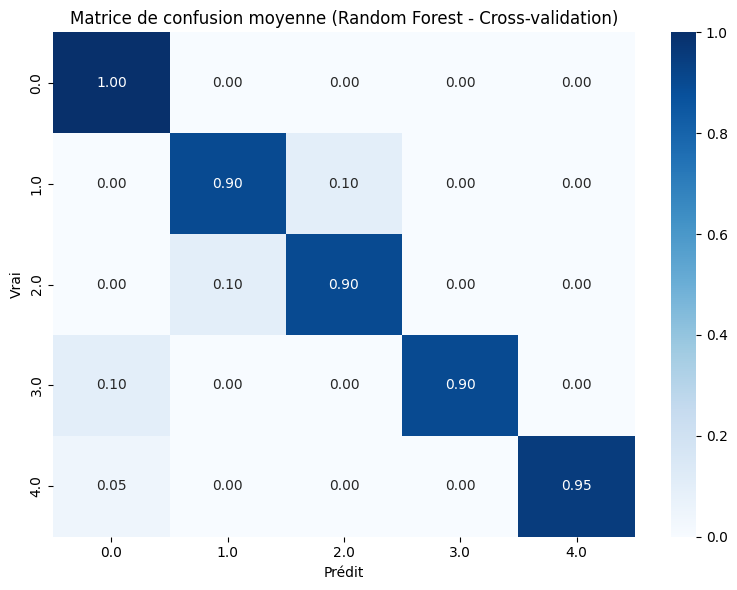

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données
df = pd.read_csv("features.csv")
patient_ids = df["patient_id"].values
X = df.drop(columns=["patient_id", "category"]).values
y = df["category"].values

X, y, patient_ids = shuffle(X, y, patient_ids, random_state=42)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

n_features = X.shape[1]
n_classes = len(np.unique(y))

# Paramètres fixes
n_estimators = 200
max_depth = None
max_features = "sqrt"

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_acc = []
all_preds = []
all_true = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        random_state=42
    )
    rf.fit(X_train, y_train)

    val_preds = rf.predict(X_val)
    acc = accuracy_score(y_val, val_preds)
    fold_acc.append(acc)

    print(f"Fold {fold+1} Accuracy: {acc:.4f}")

    all_preds.extend(val_preds)
    all_true.extend(y_val)

avg_acc = np.mean(fold_acc)
print(f"\nCross-validation terminée - Accuracy moyenne: {avg_acc:.4f}")

# === Matrice de confusion globale
conf_mat = confusion_matrix(all_true, all_preds)
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_norm, annot=True, fmt=".2f", cmap='Blues', xticklabels=np.arange(np.max(y)+1), yticklabels=np.arange(np.max(y)+1))
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion moyenne (Random Forest - Cross-validation)")
plt.tight_layout()
plt.show()

# Importance des features
### On regarde ici ce quels sont les features les plus importants pour notre Random Forest.

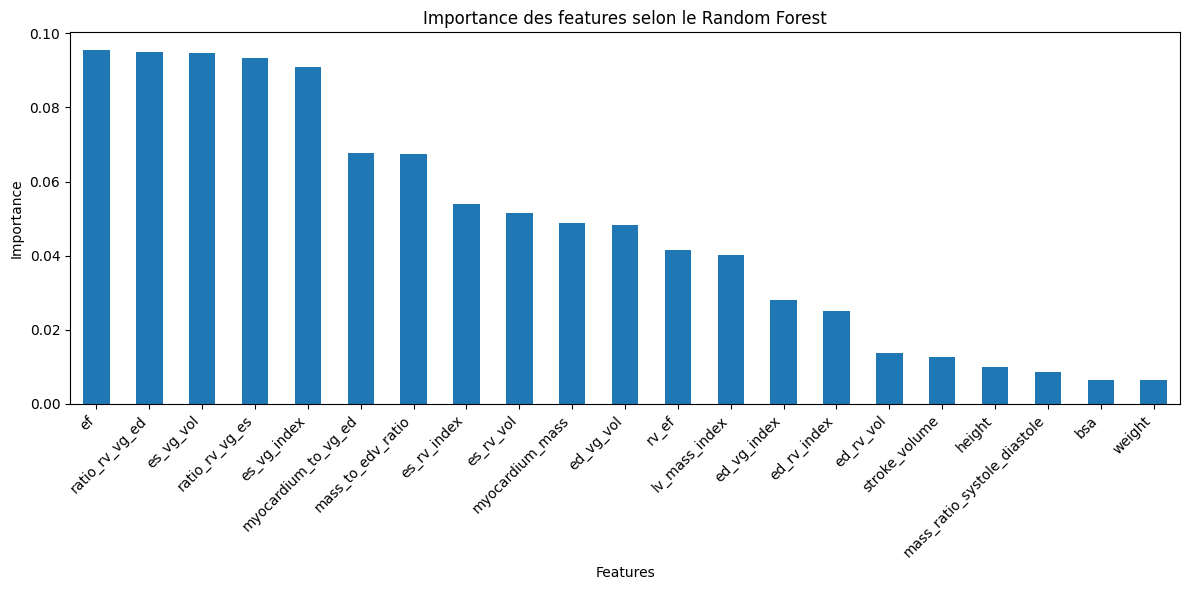

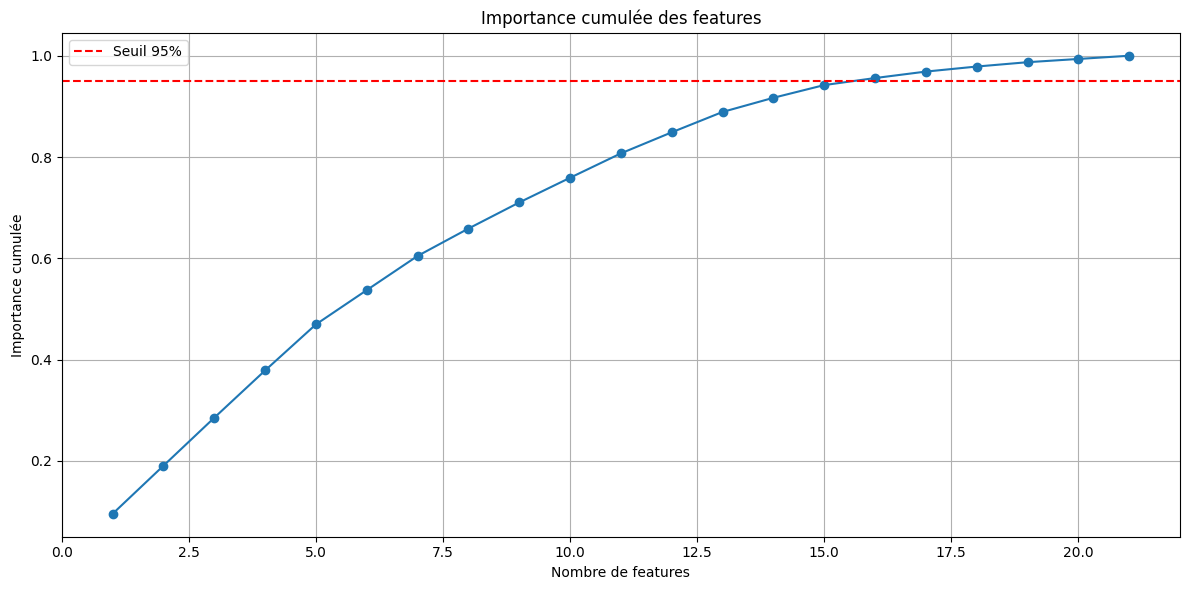


📋 Tableau des features triés du plus important au moins important :

                        Feature  Importance
0                            ef    0.095469
1                ratio_rv_vg_ed    0.094937
2                     es_vg_vol    0.094767
3                ratio_rv_vg_es    0.093348
4                   es_vg_index    0.090961
5           myocardium_to_vg_ed    0.067704
6             mass_to_edv_ratio    0.067457
7                   es_rv_index    0.054048
8                     es_rv_vol    0.051601
9               myocardium_mass    0.048752
10                    ed_vg_vol    0.048153
11                        rv_ef    0.041583
12                lv_mass_index    0.040192
13                  ed_vg_index    0.027973
14                  ed_rv_index    0.025105
15                    ed_rv_vol    0.013884
16                stroke_volume    0.012773
17                       height    0.009958
18  mass_ratio_systole_diastole    0.008568
19                          bsa    0.006393
20    

In [122]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les données
df = pd.read_csv("features_with_augmented.csv")
patient_ids = df["patient_id"].values
feature_names = df.drop(columns=["patient_id", "category"]).columns

# Importance des features
importances = rf.feature_importances_
feat_importances = pd.Series(importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

# === Affichage graphique des importances ===
plt.figure(figsize=(12, 6))
feat_importances.plot(kind="bar")
plt.title("Importance des features selon le Random Forest")
plt.ylabel("Importance")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# === Importance cumulée ===
cumulative_importance = feat_importances.cumsum()

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o')
plt.title("Importance cumulée des features")
plt.xlabel("Nombre de features")
plt.ylabel("Importance cumulée")
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label="Seuil 95%")
plt.legend()
plt.tight_layout()
plt.show()

# === Affichage sous forme de tableau ===
print("\n📋 Tableau des features triés du plus important au moins important :\n")
print(feat_importances.reset_index().rename(columns={"index": "Feature", 0: "Importance"}))

### Si on en garde que 16 on conserve 95% de l'importance cumulée.

Fold 1 Accuracy: 0.9000
Fold 2 Accuracy: 0.9500
Fold 3 Accuracy: 0.9000
Fold 4 Accuracy: 0.8000
Fold 5 Accuracy: 1.0000

Cross-validation terminée - Accuracy moyenne: 0.9100


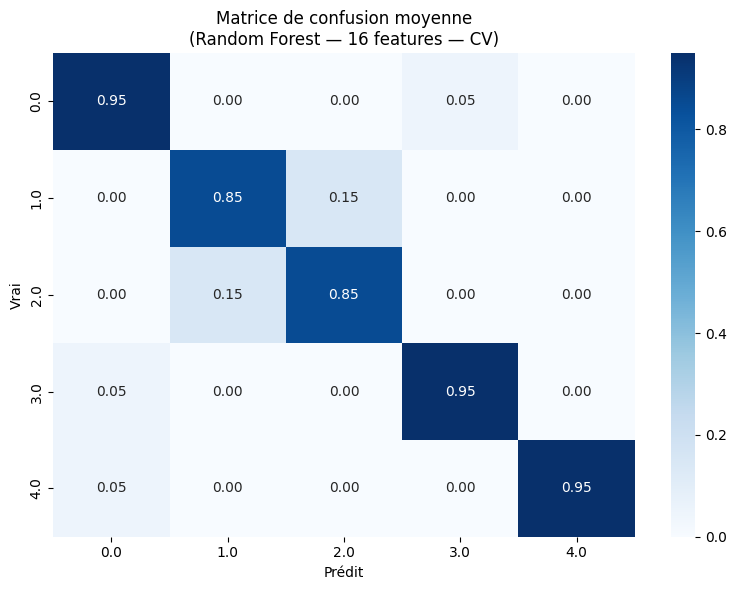

In [123]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

# === Paramètre : nombre de features importants à conserver
n_selected_features = 16

# === Chargement des données
df = pd.read_csv("features.csv")
patient_ids = df["patient_id"].values
X = df.drop(columns=["patient_id", "category"]).values
y = df["category"].values

# === Shuffle synchronisé
X, y, patient_ids = shuffle(X, y, patient_ids, random_state=42)

# === Normalisation
scaler = StandardScaler()
X = scaler.fit_transform(X)

# === Sélection des features importants
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X, y)
importances = rf_temp.feature_importances_
feat_importances = pd.Series(importances, index=df.drop(columns=["patient_id", "category"]).columns)
feat_importances = feat_importances.sort_values(ascending=False)

top_features = feat_importances.head(n_selected_features).index.tolist()
feature_indices = [list(df.drop(columns=["patient_id", "category"]).columns).index(f) for f in top_features]

# Réduire X aux seules colonnes sélectionnées
X_selected = X[:, feature_indices]

# === Cross-validation sur X_selected
n_estimators = 200
max_depth    = None
max_features = "sqrt"

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_acc = []
all_preds = []
all_true = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_selected, y)):
    X_train, X_val = X_selected[train_idx], X_selected[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    rf_selected = RandomForestClassifier(  # <-- ici renommé
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        random_state=42
    )
    rf_selected.fit(X_train, y_train)

    val_preds = rf_selected.predict(X_val)
    acc = accuracy_score(y_val, val_preds)
    fold_acc.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")

    all_preds.extend(val_preds)
    all_true.extend(y_val)

avg_acc = np.mean(fold_acc)
print(f"\nCross-validation terminée - Accuracy moyenne: {avg_acc:.4f}")

# === Matrice de confusion globale
conf_mat = confusion_matrix(all_true, all_preds)
conf_mat_norm = conf_mat.astype(float) / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_norm,
            annot=True,
            fmt=".2f",
            cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion moyenne\n(Random Forest — "
          f"{n_selected_features} features — CV)")
plt.tight_layout()
plt.show()

### Néamoins avec moins de features l'accuracy obtenue par validation croisée est moins bonne, bien que le modèle doit être plus générale. En effet le Random Forest est sensible au bruit, en enlevant des features on peut penser qu'il n'apprendra pa des données inutiles tel que du bruit.

# XGBoost
### On teste comme autre classifier le XGBoost avec le même schéma que précédement : d'abord on ragrde quels sont les paramètres optimaux par gri-search, ensuite on les applique à notre modèle qu'on test par validation croisée.

In [124]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
from itertools import product

# Paramètres du grid search pour XGBoost
n_estimators_list     = [50, 100, 200, 300, 500]
max_depth_list        = [3, 6, 9]
learning_rate_list    = [0.01, 0.1, 0.2]
colsample_bytree_list = [0.6, 0.8, 1.0]

results = []
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for n_estimators, max_depth, learning_rate, colsample in product(
    n_estimators_list,
    max_depth_list,
    learning_rate_list,
    colsample_bytree_list
):
    print(f"\nTest config → n_estimators={n_estimators}, max_depth={max_depth}, "
          f"learning_rate={learning_rate}, colsample_bytree={colsample}")
    fold_acc = []
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        xgb = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            colsample_bytree=colsample,
            use_label_encoder=False,
            eval_metric="mlogloss",
            random_state=42
        )
        xgb.fit(X_train, y_train)
        val_preds = xgb.predict(X_val)
        fold_acc.append(accuracy_score(y_val, val_preds))

    avg_acc = np.mean(fold_acc)
    results.append({
        "n_estimators":     n_estimators,
        "max_depth":        max_depth,
        "learning_rate":    learning_rate,
        "colsample_bytree": colsample,
        "accuracy":         avg_acc
    })
    print(f"→ Accuracy moyenne : {avg_acc:.4f}")

# Affichage des meilleurs paramètres
results_sorted = sorted(results, key=lambda x: x["accuracy"], reverse=True)
print("\n=== Meilleurs paramètres XGBoost ===")
for res in results_sorted[:5]:
    print(res)


Test config → n_estimators=50, max_depth=3, learning_rate=0.01, colsample_bytree=0.6
→ Accuracy moyenne : 0.9100

Test config → n_estimators=50, max_depth=3, learning_rate=0.01, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:34] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=50, max_depth=3, learning_rate=0.01, colsample_bytree=1.0
→ Accuracy moyenne : 0.8800

Test config → n_estimators=50, max_depth=3, learning_rate=0.1, colsample_bytree=0.6
→ Accuracy moyenne : 0.9100

Test config → n_estimators=50, max_depth=3, learning_rate=0.1, colsample_bytree=0.8
→ Accuracy moyenne : 0.9000

Test config → n_estimators=50, max_depth=3, learning_rate=0.1, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:35] WARN

→ Accuracy moyenne : 0.9000

Test config → n_estimators=50, max_depth=3, learning_rate=0.2, colsample_bytree=0.6
→ Accuracy moyenne : 0.9100

Test config → n_estimators=50, max_depth=3, learning_rate=0.2, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:35] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=50, max_depth=3, learning_rate=0.2, colsample_bytree=1.0
→ Accuracy moyenne : 0.9100

Test config → n_estimators=50, max_depth=6, learning_rate=0.01, colsample_bytree=0.6
→ Accuracy moyenne : 0.9100

Test config → n_estimators=50, max_depth=6, learning_rate=0.01, colsample_bytree=0.8
→ Accuracy moyenne : 0.9000

Test config → n_estimators=50, max_depth=6, learning_rate=0.01, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:35] WARN

→ Accuracy moyenne : 0.8700

Test config → n_estimators=50, max_depth=6, learning_rate=0.1, colsample_bytree=0.6
→ Accuracy moyenne : 0.9000

Test config → n_estimators=50, max_depth=6, learning_rate=0.1, colsample_bytree=0.8
→ Accuracy moyenne : 0.9000

Test config → n_estimators=50, max_depth=6, learning_rate=0.1, colsample_bytree=1.0
→ Accuracy moyenne : 0.9000

Test config → n_estimators=50, max_depth=6, learning_rate=0.2, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:35] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=50, max_depth=6, learning_rate=0.2, colsample_bytree=0.8
→ Accuracy moyenne : 0.9100

Test config → n_estimators=50, max_depth=6, learning_rate=0.2, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:35] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=50, max_depth=9, learning_rate=0.01, colsample_bytree=0.6
→ Accuracy moyenne : 0.9100

Test config → n_estimators=50, max_depth=9, learning_rate=0.01, colsample_bytree=0.8
→ Accuracy moyenne : 0.9000

Test config → n_estimators=50, max_depth=9, learning_rate=0.01, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:36] WARN

→ Accuracy moyenne : 0.8700

Test config → n_estimators=50, max_depth=9, learning_rate=0.1, colsample_bytree=0.6
→ Accuracy moyenne : 0.9000

Test config → n_estimators=50, max_depth=9, learning_rate=0.1, colsample_bytree=0.8
→ Accuracy moyenne : 0.9000

Test config → n_estimators=50, max_depth=9, learning_rate=0.1, colsample_bytree=1.0
→ Accuracy moyenne : 0.9000

Test config → n_estimators=50, max_depth=9, learning_rate=0.2, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:36] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=50, max_depth=9, learning_rate=0.2, colsample_bytree=0.8
→ Accuracy moyenne : 0.9100

Test config → n_estimators=50, max_depth=9, learning_rate=0.2, colsample_bytree=1.0
→ Accuracy moyenne : 0.9100

Test config → n_estimators=100, max_depth=3, learning_rate=0.01, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:36] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=100, max_depth=3, learning_rate=0.01, colsample_bytree=0.8
→ Accuracy moyenne : 0.9100

Test config → n_estimators=100, max_depth=3, learning_rate=0.01, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:36] WARN

→ Accuracy moyenne : 0.8700

Test config → n_estimators=100, max_depth=3, learning_rate=0.1, colsample_bytree=0.6
→ Accuracy moyenne : 0.9100

Test config → n_estimators=100, max_depth=3, learning_rate=0.1, colsample_bytree=0.8
→ Accuracy moyenne : 0.9100

Test config → n_estimators=100, max_depth=3, learning_rate=0.1, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:36] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=100, max_depth=3, learning_rate=0.2, colsample_bytree=0.6
→ Accuracy moyenne : 0.9100

Test config → n_estimators=100, max_depth=3, learning_rate=0.2, colsample_bytree=0.8
→ Accuracy moyenne : 0.9100

Test config → n_estimators=100, max_depth=3, learning_rate=0.2, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:37] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=100, max_depth=6, learning_rate=0.01, colsample_bytree=0.6
→ Accuracy moyenne : 0.9000

Test config → n_estimators=100, max_depth=6, learning_rate=0.01, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:37] WARN

→ Accuracy moyenne : 0.9000

Test config → n_estimators=100, max_depth=6, learning_rate=0.01, colsample_bytree=1.0
→ Accuracy moyenne : 0.8700

Test config → n_estimators=100, max_depth=6, learning_rate=0.1, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:37] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=100, max_depth=6, learning_rate=0.1, colsample_bytree=0.8
→ Accuracy moyenne : 0.9100

Test config → n_estimators=100, max_depth=6, learning_rate=0.1, colsample_bytree=1.0
→ Accuracy moyenne : 0.9100

Test config → n_estimators=100, max_depth=6, learning_rate=0.2, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:37] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=100, max_depth=6, learning_rate=0.2, colsample_bytree=0.8
→ Accuracy moyenne : 0.9100

Test config → n_estimators=100, max_depth=6, learning_rate=0.2, colsample_bytree=1.0
→ Accuracy moyenne : 0.9100

Test config → n_estimators=100, max_depth=9, learning_rate=0.01, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:38] WARN

→ Accuracy moyenne : 0.9000

Test config → n_estimators=100, max_depth=9, learning_rate=0.01, colsample_bytree=0.8
→ Accuracy moyenne : 0.9000

Test config → n_estimators=100, max_depth=9, learning_rate=0.01, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:38] WARN

→ Accuracy moyenne : 0.8700

Test config → n_estimators=100, max_depth=9, learning_rate=0.1, colsample_bytree=0.6
→ Accuracy moyenne : 0.9100

Test config → n_estimators=100, max_depth=9, learning_rate=0.1, colsample_bytree=0.8
→ Accuracy moyenne : 0.9100

Test config → n_estimators=100, max_depth=9, learning_rate=0.1, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:38] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=100, max_depth=9, learning_rate=0.2, colsample_bytree=0.6
→ Accuracy moyenne : 0.9100

Test config → n_estimators=100, max_depth=9, learning_rate=0.2, colsample_bytree=0.8
→ Accuracy moyenne : 0.9100

Test config → n_estimators=100, max_depth=9, learning_rate=0.2, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:39] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=3, learning_rate=0.01, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:39] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=3, learning_rate=0.01, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:39] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=3, learning_rate=0.01, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:40] WARN

→ Accuracy moyenne : 0.9000

Test config → n_estimators=200, max_depth=3, learning_rate=0.1, colsample_bytree=0.6
→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=3, learning_rate=0.1, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:40] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=3, learning_rate=0.1, colsample_bytree=1.0
→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=3, learning_rate=0.2, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:40] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=3, learning_rate=0.2, colsample_bytree=0.8
→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=3, learning_rate=0.2, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:40] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=6, learning_rate=0.01, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:41] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=6, learning_rate=0.01, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:41] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=6, learning_rate=0.01, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:41] WARN

→ Accuracy moyenne : 0.8900

Test config → n_estimators=200, max_depth=6, learning_rate=0.1, colsample_bytree=0.6
→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=6, learning_rate=0.1, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:42] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=6, learning_rate=0.1, colsample_bytree=1.0
→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=6, learning_rate=0.2, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:42] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=6, learning_rate=0.2, colsample_bytree=0.8
→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=6, learning_rate=0.2, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:42] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=9, learning_rate=0.01, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:42] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=9, learning_rate=0.01, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:43] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=9, learning_rate=0.01, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:43] WARN

→ Accuracy moyenne : 0.8900

Test config → n_estimators=200, max_depth=9, learning_rate=0.1, colsample_bytree=0.6
→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=9, learning_rate=0.1, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:43] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=9, learning_rate=0.1, colsample_bytree=1.0
→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=9, learning_rate=0.2, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:44] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=9, learning_rate=0.2, colsample_bytree=0.8
→ Accuracy moyenne : 0.9100

Test config → n_estimators=200, max_depth=9, learning_rate=0.2, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:44] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=3, learning_rate=0.01, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=3, learning_rate=0.01, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:45] WARN

→ Accuracy moyenne : 0.9000

Test config → n_estimators=300, max_depth=3, learning_rate=0.01, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


→ Accuracy moyenne : 0.9000

Test config → n_estimators=300, max_depth=3, learning_rate=0.1, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:45] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=3, learning_rate=0.1, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:45] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=3, learning_rate=0.1, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:46] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=3, learning_rate=0.2, colsample_bytree=0.6
→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=3, learning_rate=0.2, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:46] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=3, learning_rate=0.2, colsample_bytree=1.0
→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=6, learning_rate=0.01, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:46] WARN

→ Accuracy moyenne : 0.9000

Test config → n_estimators=300, max_depth=6, learning_rate=0.01, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:47] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=6, learning_rate=0.01, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:47] WARN

→ Accuracy moyenne : 0.9000

Test config → n_estimators=300, max_depth=6, learning_rate=0.1, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:48] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=6, learning_rate=0.1, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:48] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=6, learning_rate=0.1, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:48] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=6, learning_rate=0.2, colsample_bytree=0.6
→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=6, learning_rate=0.2, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:48] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=6, learning_rate=0.2, colsample_bytree=1.0
→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=9, learning_rate=0.01, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:49] WARN

→ Accuracy moyenne : 0.9000

Test config → n_estimators=300, max_depth=9, learning_rate=0.01, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:49] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=9, learning_rate=0.01, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


→ Accuracy moyenne : 0.9000

Test config → n_estimators=300, max_depth=9, learning_rate=0.1, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:50] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=9, learning_rate=0.1, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:50] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=9, learning_rate=0.1, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:50] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=9, learning_rate=0.2, colsample_bytree=0.6
→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=9, learning_rate=0.2, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:51] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=300, max_depth=9, learning_rate=0.2, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:51] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=500, max_depth=3, learning_rate=0.01, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:52] WARN

→ Accuracy moyenne : 0.9000

Test config → n_estimators=500, max_depth=3, learning_rate=0.01, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:52] WARN

→ Accuracy moyenne : 0.9000

Test config → n_estimators=500, max_depth=3, learning_rate=0.01, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:53] WARN

→ Accuracy moyenne : 0.9000

Test config → n_estimators=500, max_depth=3, learning_rate=0.1, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:53] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=500, max_depth=3, learning_rate=0.1, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:54] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=500, max_depth=3, learning_rate=0.1, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


→ Accuracy moyenne : 0.9100

Test config → n_estimators=500, max_depth=3, learning_rate=0.2, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:54] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=500, max_depth=3, learning_rate=0.2, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:54] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=500, max_depth=3, learning_rate=0.2, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:55] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=500, max_depth=6, learning_rate=0.01, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:55] WARN

→ Accuracy moyenne : 0.9000

Test config → n_estimators=500, max_depth=6, learning_rate=0.01, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:56] WARN

→ Accuracy moyenne : 0.9000

Test config → n_estimators=500, max_depth=6, learning_rate=0.01, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:56] WARN

→ Accuracy moyenne : 0.9000

Test config → n_estimators=500, max_depth=6, learning_rate=0.1, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:57] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=500, max_depth=6, learning_rate=0.1, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


→ Accuracy moyenne : 0.9100

Test config → n_estimators=500, max_depth=6, learning_rate=0.1, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:57] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=500, max_depth=6, learning_rate=0.2, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:58] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=500, max_depth=6, learning_rate=0.2, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:58] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=500, max_depth=6, learning_rate=0.2, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:58] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=500, max_depth=9, learning_rate=0.01, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:59] WARN

→ Accuracy moyenne : 0.9000

Test config → n_estimators=500, max_depth=9, learning_rate=0.01, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:51:59] WARN

→ Accuracy moyenne : 0.9000

Test config → n_estimators=500, max_depth=9, learning_rate=0.01, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:00] WARN

→ Accuracy moyenne : 0.9000

Test config → n_estimators=500, max_depth=9, learning_rate=0.1, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:01] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=500, max_depth=9, learning_rate=0.1, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:01] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=500, max_depth=9, learning_rate=0.1, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:01] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=500, max_depth=9, learning_rate=0.2, colsample_bytree=0.6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:02] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=500, max_depth=9, learning_rate=0.2, colsample_bytree=0.8


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:02] WARN

→ Accuracy moyenne : 0.9100

Test config → n_estimators=500, max_depth=9, learning_rate=0.2, colsample_bytree=1.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:02] WARN

→ Accuracy moyenne : 0.9100

=== Meilleurs paramètres XGBoost ===
{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'accuracy': 0.9099999999999999}
{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8, 'accuracy': 0.9099999999999999}
{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'accuracy': 0.9099999999999999}
{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.6, 'accuracy': 0.9099999999999999}
{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.8, 'accuracy': 0.9099999999999999}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:52:02] WARN

Fold 1 Accuracy: 0.9000
Fold 2 Accuracy: 0.9500
Fold 3 Accuracy: 0.9000
Fold 4 Accuracy: 0.8000
Fold 5 Accuracy: 1.0000

Cross-validation terminée - Accuracy moyenne: 0.9100


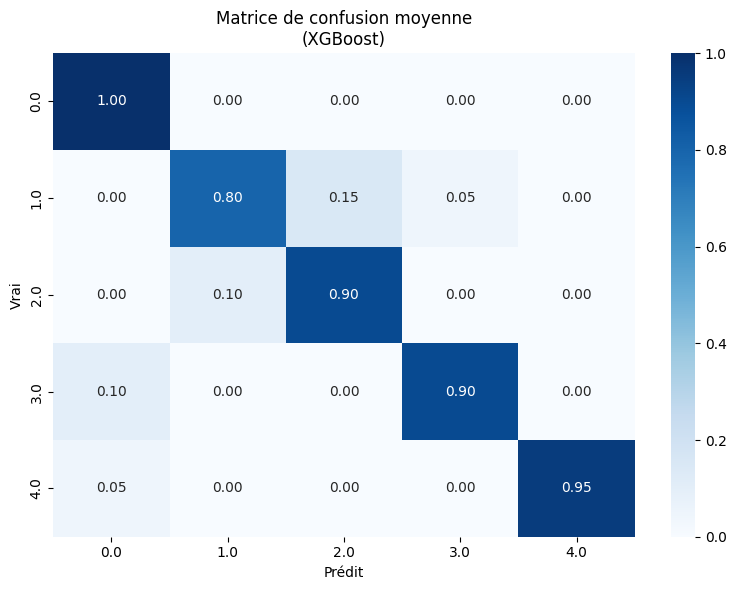

In [125]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

# === Chargement des données
df = pd.read_csv("features.csv")
patient_ids = df["patient_id"].values
X = df.drop(columns=["patient_id", "category"]).values
y = df["category"].values

# === Shuffle synchronisé
X, y, patient_ids = shuffle(X, y, patient_ids, random_state=42)

# === Normalisation
scaler = StandardScaler()
X = scaler.fit_transform(X)

# === Cross-validation sur toutes les features avec XGBoost
n_estimators   = 50
max_depth      = 3
learning_rate  = 0.01
colsample      = 0.6

kfold    = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_acc = []
all_preds = []
all_true  = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    xgb = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        colsample_bytree=colsample,
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=42
    )
    xgb.fit(X_train, y_train)

    val_preds = xgb.predict(X_val)
    acc = accuracy_score(y_val, val_preds)
    fold_acc.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")

    all_preds.extend(val_preds)
    all_true.extend(y_val)

avg_acc = np.mean(fold_acc)
print(f"\nCross-validation terminée - Accuracy moyenne: {avg_acc:.4f}")

# === Matrice de confusion globale
conf_mat = confusion_matrix(all_true, all_preds)
conf_mat_norm = conf_mat.astype(float) / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_norm,
            annot=True,
            fmt=".2f",
            cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion moyenne\n(XGBoost)")
plt.tight_layout()
plt.show()

# SVM
### On teste comme autre classifier le SVM avec le même schéma que précédement : d'abord on ragrde quels sont les paramètres optimaux par gri-search, ensuite on les applique à notre modèle qu'on test par validation croisée.

In [126]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
from itertools import product

# Paramètres du grid search pour SVM
C_list      = [0.1, 1, 10]
kernel_list = ['linear', 'rbf']
gamma_list  = ['scale', 'auto']

results = []
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for C, kernel, gamma in product(C_list, kernel_list, gamma_list):
    print(f"\nTest config → C={C}, kernel={kernel}, gamma={gamma}")
    fold_acc = []
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        svm = SVC(
            C=C,
            kernel=kernel,
            gamma=gamma,
            random_state=42
        )
        svm.fit(X_train, y_train)
        val_preds = svm.predict(X_val)
        fold_acc.append(accuracy_score(y_val, val_preds))

    avg_acc = np.mean(fold_acc)
    results.append({
        "C":      C,
        "kernel": kernel,
        "gamma":  gamma,
        "accuracy": avg_acc
    })
    print(f"→ Accuracy moyenne : {avg_acc:.4f}")

# Affichage des meilleurs paramètres
results_sorted = sorted(results, key=lambda x: x["accuracy"], reverse=True)
print("\n=== Meilleurs paramètres SVM ===")
for res in results_sorted[:5]:
    print(res)


Test config → C=0.1, kernel=linear, gamma=scale
→ Accuracy moyenne : 0.9300

Test config → C=0.1, kernel=linear, gamma=auto
→ Accuracy moyenne : 0.9300

Test config → C=0.1, kernel=rbf, gamma=scale
→ Accuracy moyenne : 0.8500

Test config → C=0.1, kernel=rbf, gamma=auto
→ Accuracy moyenne : 0.8500

Test config → C=1, kernel=linear, gamma=scale
→ Accuracy moyenne : 0.9100

Test config → C=1, kernel=linear, gamma=auto
→ Accuracy moyenne : 0.9100

Test config → C=1, kernel=rbf, gamma=scale
→ Accuracy moyenne : 0.9200

Test config → C=1, kernel=rbf, gamma=auto
→ Accuracy moyenne : 0.9200

Test config → C=10, kernel=linear, gamma=scale
→ Accuracy moyenne : 0.9500

Test config → C=10, kernel=linear, gamma=auto
→ Accuracy moyenne : 0.9500

Test config → C=10, kernel=rbf, gamma=scale
→ Accuracy moyenne : 0.9400

Test config → C=10, kernel=rbf, gamma=auto
→ Accuracy moyenne : 0.9400

=== Meilleurs paramètres SVM ===
{'C': 10, 'kernel': 'linear', 'gamma': 'scale', 'accuracy': 0.95}
{'C': 10, 'k

Fold 1 Accuracy: 0.9000
Fold 2 Accuracy: 0.9500
Fold 3 Accuracy: 1.0000
Fold 4 Accuracy: 0.9000
Fold 5 Accuracy: 1.0000

Cross-validation terminée - Accuracy moyenne: 0.9500


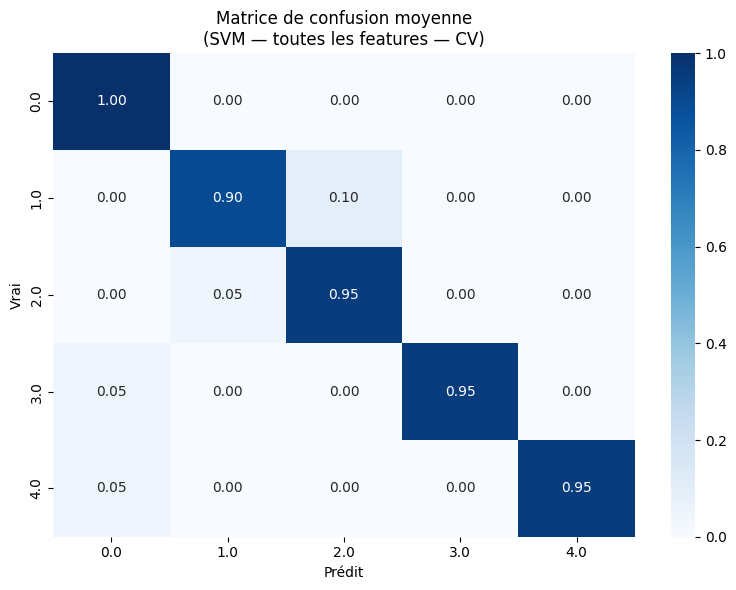

In [127]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

# === Chargement des données
df = pd.read_csv("features.csv")
patient_ids = df["patient_id"].values
X = df.drop(columns=["patient_id", "category"]).values
y = df["category"].values

# === Shuffle synchronisé
X, y, patient_ids = shuffle(X, y, patient_ids, random_state=42)

# === Normalisation
scaler = StandardScaler()
X = scaler.fit_transform(X)

# === Hyperparamètres SVM
C      = 10
kernel = 'linear'
gamma  = 'auto'

# === Cross-validation 5 folds
kfold    = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_acc = []
all_preds = []
all_true  = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    svm = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        probability=False,
        random_state=42
    )
    svm.fit(X_train, y_train)

    val_preds = svm.predict(X_val)
    acc = accuracy_score(y_val, val_preds)
    fold_acc.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")

    all_preds.extend(val_preds)
    all_true.extend(y_val)

avg_acc = np.mean(fold_acc)
print(f"\nCross-validation terminée - Accuracy moyenne: {avg_acc:.4f}")

# === Matrice de confusion globale
conf_mat = confusion_matrix(all_true, all_preds)
conf_mat_norm = conf_mat.astype(float) / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_norm,
            annot=True,
            fmt=".2f",
            cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion moyenne\n(SVM — toutes les features — CV)")
plt.tight_layout()
plt.show()

# KNN
### On teste comme autre classifier le KNN avec le même schéma que précédement : d'abord on ragrde quels sont les paramètres optimaux par gri-search, ensuite on les applique à notre modèle qu'on test par validation croisée.

In [128]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
from itertools import product

# Paramètres du grid search pour KNN
n_neighbors_list = [3, 5, 7, 9]
weights_list     = ['uniform', 'distance']
metric_list      = ['euclidean', 'manhattan']

results = []
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for n_neighbors, weights, metric in product(n_neighbors_list, weights_list, metric_list):
    print(f"\nTest config → n_neighbors={n_neighbors}, weights={weights}, metric={metric}")
    fold_acc = []
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        knn = KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights,
            metric=metric
        )
        knn.fit(X_train, y_train)
        val_preds = knn.predict(X_val)
        fold_acc.append(accuracy_score(y_val, val_preds))

    avg_acc = np.mean(fold_acc)
    results.append({
        "n_neighbors": n_neighbors,
        "weights":      weights,
        "metric":       metric,
        "accuracy":     avg_acc
    })
    print(f"→ Accuracy moyenne : {avg_acc:.4f}")

# Affichage des meilleurs paramètres
results_sorted = sorted(results, key=lambda x: x["accuracy"], reverse=True)
print("\n=== Meilleurs paramètres KNN ===")
for res in results_sorted[:5]:
    print(res)


Test config → n_neighbors=3, weights=uniform, metric=euclidean
→ Accuracy moyenne : 0.8900

Test config → n_neighbors=3, weights=uniform, metric=manhattan
→ Accuracy moyenne : 0.9300

Test config → n_neighbors=3, weights=distance, metric=euclidean
→ Accuracy moyenne : 0.8900

Test config → n_neighbors=3, weights=distance, metric=manhattan
→ Accuracy moyenne : 0.9300

Test config → n_neighbors=5, weights=uniform, metric=euclidean
→ Accuracy moyenne : 0.8300

Test config → n_neighbors=5, weights=uniform, metric=manhattan
→ Accuracy moyenne : 0.8900

Test config → n_neighbors=5, weights=distance, metric=euclidean
→ Accuracy moyenne : 0.8600

Test config → n_neighbors=5, weights=distance, metric=manhattan
→ Accuracy moyenne : 0.9300

Test config → n_neighbors=7, weights=uniform, metric=euclidean
→ Accuracy moyenne : 0.8000

Test config → n_neighbors=7, weights=uniform, metric=manhattan
→ Accuracy moyenne : 0.8700

Test config → n_neighbors=7, weights=distance, metric=euclidean
→ Accuracy 

# On teste le knn avec les meilleurs paramètres

Fold 1 Accuracy: 0.9000
Fold 2 Accuracy: 0.9500
Fold 3 Accuracy: 0.9500
Fold 4 Accuracy: 0.9000
Fold 5 Accuracy: 0.9500

Cross-validation terminée - Accuracy moyenne: 0.9300


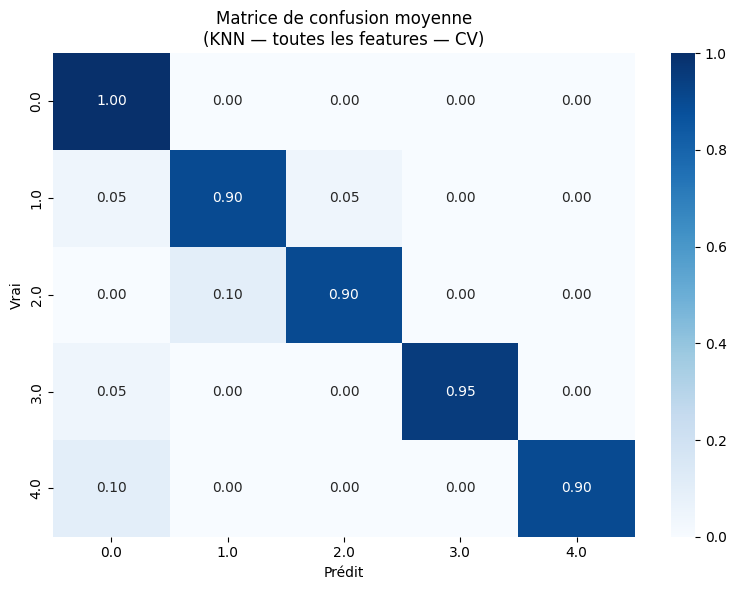

In [129]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

# === Chargement des données
df = pd.read_csv("features.csv")
patient_ids = df["patient_id"].values
X = df.drop(columns=["patient_id", "category"]).values
y = df["category"].values

# === Shuffle synchronisé
X, y, patient_ids = shuffle(X, y, patient_ids, random_state=42)

# === Normalisation
scaler = StandardScaler()
X = scaler.fit_transform(X)

# === Hyperparamètres KNN
n_neighbors = 3
weights     = 'uniform'
metric      = 'manhattan'

# === Cross-validation 5 folds
kfold    = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_acc = []
all_preds = []
all_true  = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric
    )
    knn.fit(X_train, y_train)

    val_preds = knn.predict(X_val)
    acc = accuracy_score(y_val, val_preds)
    fold_acc.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")

    all_preds.extend(val_preds)
    all_true.extend(y_val)

avg_acc = np.mean(fold_acc)
print(f"\nCross-validation terminée - Accuracy moyenne: {avg_acc:.4f}")

# === Matrice de confusion globale
conf_mat = confusion_matrix(all_true, all_preds)
conf_mat_norm = conf_mat.astype(float) / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_norm,
            annot=True,
            fmt=".2f",
            cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion moyenne\n(KNN — toutes les features — CV)")
plt.tight_layout()
plt.show()

# Méthode ensemble
### Enfin on combine par méthode ensemble les classifieurs qu'on a trouvé performants. Ici on combinera les MLPs avec le Random Forest et avec le SVM.

### On commence par le Random Forest.


======= Proportion MLP = 0.00 =======
Fold 1 Accuracy : 1.0000
Fold 2 Accuracy : 0.9500
Fold 3 Accuracy : 0.9500
Fold 4 Accuracy : 0.9500
Fold 5 Accuracy : 0.8000
✅ Accuracy Moyenne pour proportion 0.00: 0.9300

======= Proportion MLP = 0.10 =======
Fold 1 Accuracy : 1.0000
Fold 2 Accuracy : 0.9500
Fold 3 Accuracy : 0.9500
Fold 4 Accuracy : 0.9500
Fold 5 Accuracy : 0.8000
✅ Accuracy Moyenne pour proportion 0.10: 0.9300

======= Proportion MLP = 0.20 =======
Fold 1 Accuracy : 1.0000
Fold 2 Accuracy : 0.9500
Fold 3 Accuracy : 0.9500
Fold 4 Accuracy : 0.9500
Fold 5 Accuracy : 0.8000
✅ Accuracy Moyenne pour proportion 0.20: 0.9300

======= Proportion MLP = 0.30 =======
Fold 1 Accuracy : 1.0000
Fold 2 Accuracy : 0.9500
Fold 3 Accuracy : 0.9500
Fold 4 Accuracy : 0.9500
Fold 5 Accuracy : 0.8000
✅ Accuracy Moyenne pour proportion 0.30: 0.9300

======= Proportion MLP = 0.40 =======
Fold 1 Accuracy : 1.0000
Fold 2 Accuracy : 0.9500
Fold 3 Accuracy : 0.9500
Fold 4 Accuracy : 0.9500
Fold 5 Accura

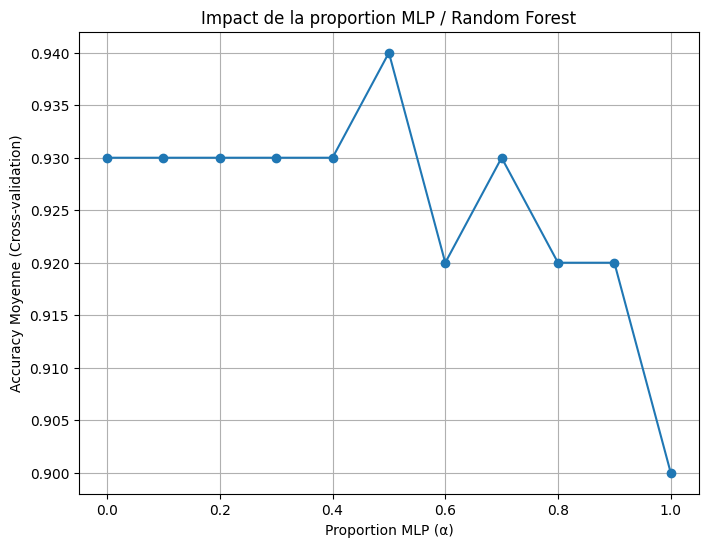

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# === Charger les données
df = pd.read_csv("features.csv")
X = df.drop(columns=["patient_id", "category"]).values
y = df["category"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

n_features = X.shape[1]
n_classes = len(np.unique(y))

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# === Proportions MLP / RF à tester
proportions = np.linspace(0, 1, 11)  # 0.0, 0.1, ..., 1.0
results = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for alpha in proportions:
    print(f"\n======= Proportion MLP = {alpha:.2f} =======")
    fold_acc = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
        y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

        # === Random Forest ===
        rf = RandomForestClassifier(n_estimators=200, max_depth=None, max_features="sqrt", random_state=42)
        rf.fit(X_train.numpy(), y_train.numpy())
        rf_probs = rf.predict_proba(X_val.numpy())

        # === MLP ensemble ===
        n_mlps = 50
        batch_size = 30
        n_epochs = 200
        softmax = torch.nn.Softmax(dim=1)

        mlp_probs_ensemble = []

        for model_num in range(n_mlps):
            idx_patients = np.random.choice(len(X_train), int(0.75 * len(X_train)), replace=False)
            idx_features = np.sort(np.random.choice(n_features, int(2 * n_features / 3), replace=False))

            X_sub = X_train[idx_patients][:, idx_features]
            y_sub = y_train[idx_patients]

            loader = DataLoader(TensorDataset(X_sub, y_sub), batch_size=batch_size, shuffle=True)

            model = MLP(input_dim=len(idx_features), output_dim=n_classes)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
            criterion = nn.CrossEntropyLoss()

            model.train()
            for _ in range(n_epochs):
                for xb, yb in loader:
                    out = model(xb)
                    loss = criterion(out, yb)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            model.eval()
            with torch.no_grad():
                logits = model(X_val[:, idx_features])
                probs = softmax(logits).cpu().numpy()
                mlp_probs_ensemble.append(probs)

        # === Moyenne des prédictions MLP
        mlp_probs_ensemble = np.stack(mlp_probs_ensemble, axis=0)
        mlp_probs_mean = mlp_probs_ensemble.mean(axis=0)

        # === Fusion des prédictions
        final_probs = alpha * mlp_probs_mean + (1 - alpha) * rf_probs
        final_preds = np.argmax(final_probs, axis=1)

        acc = accuracy_score(y_val.numpy(), final_preds)
        fold_acc.append(acc)

        print(f"Fold {fold+1} Accuracy : {acc:.4f}")

    avg_acc = np.mean(fold_acc)
    results.append(avg_acc)
    print(f" Accuracy Moyenne pour proportion {alpha:.2f}: {avg_acc:.4f}")

# === Tracer la courbe
plt.figure(figsize=(8,6))
plt.plot(proportions, results, marker='o')
plt.xlabel("Proportion MLP (α)")
plt.ylabel("Accuracy Moyenne (Cross-validation)")
plt.title("Impact de la proportion MLP / Random Forest")
plt.grid(True)
plt.show()

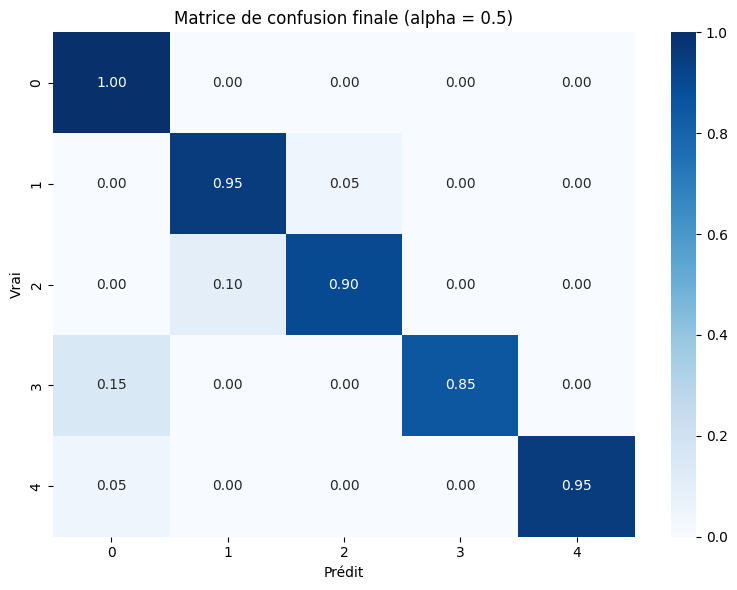


✅ Accuracy moyenne finale (alpha = 0.5) : 0.9300


In [146]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Chargement des données
df = pd.read_csv("features.csv")
X = df.drop(columns=["patient_id", "category"]).values
y = df["category"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

n_features = X.shape[1]
n_classes = len(np.unique(y))

# === Définition du MLP
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# === Cross-validation avec alpha = 0.5
alpha = 0.5
all_preds = []
all_true = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
    y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

    # === Random Forest
    rf = RandomForestClassifier(n_estimators=200, max_depth=None, max_features="sqrt", random_state=42)
    rf.fit(X_train.numpy(), y_train.numpy())
    rf_probs = rf.predict_proba(X_val.numpy())

    # === MLP ensemble
    n_mlps = 50
    batch_size = 30
    n_epochs = 200
    softmax = torch.nn.Softmax(dim=1)
    mlp_probs_ensemble = []

    for model_num in range(n_mlps):
        idx_patients = np.random.choice(len(X_train), int(0.75 * len(X_train)), replace=False)
        idx_features = np.sort(np.random.choice(n_features, int(2 * n_features / 3), replace=False))

        X_sub = X_train[idx_patients][:, idx_features]
        y_sub = y_train[idx_patients]

        loader = DataLoader(TensorDataset(X_sub, y_sub), batch_size=batch_size, shuffle=True)

        model = MLP(input_dim=len(idx_features), output_dim=n_classes)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        model.train()
        for _ in range(n_epochs):
            for xb, yb in loader:
                out = model(xb)
                loss = criterion(out, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        model.eval()
        with torch.no_grad():
            logits = model(X_val[:, idx_features])
            probs = softmax(logits).cpu().numpy()
            mlp_probs_ensemble.append(probs)

    # === Moyenne des prédictions MLP
    mlp_probs_ensemble = np.stack(mlp_probs_ensemble, axis=0)
    mlp_probs_mean = mlp_probs_ensemble.mean(axis=0)

    # === Fusion avec alpha = 0.5
    final_probs = alpha * mlp_probs_mean + (1 - alpha) * rf_probs
    final_preds = np.argmax(final_probs, axis=1)

    all_preds.extend(final_preds)
    all_true.extend(y_val.numpy())

# === Matrice de confusion finale
conf_mat = confusion_matrix(all_true, all_preds)
conf_mat_norm = conf_mat.astype(float) / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_norm, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=np.arange(n_classes),
            yticklabels=np.arange(n_classes))
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion finale (alpha = 0.5)")
plt.tight_layout()
plt.show()

# === Accuracy moyenne globale
all_preds = np.array(all_preds)
all_true = np.array(all_true)
avg_acc = accuracy_score(all_true, all_preds)
print(f"\n✅ Accuracy moyenne finale (alpha = 0.5) : {avg_acc:.4f}")

# On passe à la méthode ensemble avec le SVM


======= Proportion MLP = 0.00 =======
✅ Accuracy Moyenne pour proportion 0.00: 0.9300

======= Proportion MLP = 0.10 =======
✅ Accuracy Moyenne pour proportion 0.10: 0.9300

======= Proportion MLP = 0.20 =======
✅ Accuracy Moyenne pour proportion 0.20: 0.9300

======= Proportion MLP = 0.30 =======
✅ Accuracy Moyenne pour proportion 0.30: 0.9400

======= Proportion MLP = 0.40 =======
✅ Accuracy Moyenne pour proportion 0.40: 0.9300

======= Proportion MLP = 0.50 =======
✅ Accuracy Moyenne pour proportion 0.50: 0.9200

======= Proportion MLP = 0.60 =======
✅ Accuracy Moyenne pour proportion 0.60: 0.9400

======= Proportion MLP = 0.70 =======
✅ Accuracy Moyenne pour proportion 0.70: 0.9300

======= Proportion MLP = 0.80 =======
✅ Accuracy Moyenne pour proportion 0.80: 0.9200

======= Proportion MLP = 0.90 =======
✅ Accuracy Moyenne pour proportion 0.90: 0.9300

======= Proportion MLP = 1.00 =======
✅ Accuracy Moyenne pour proportion 1.00: 0.9100

⭐ Meilleure proportion alpha: 0.3000000000

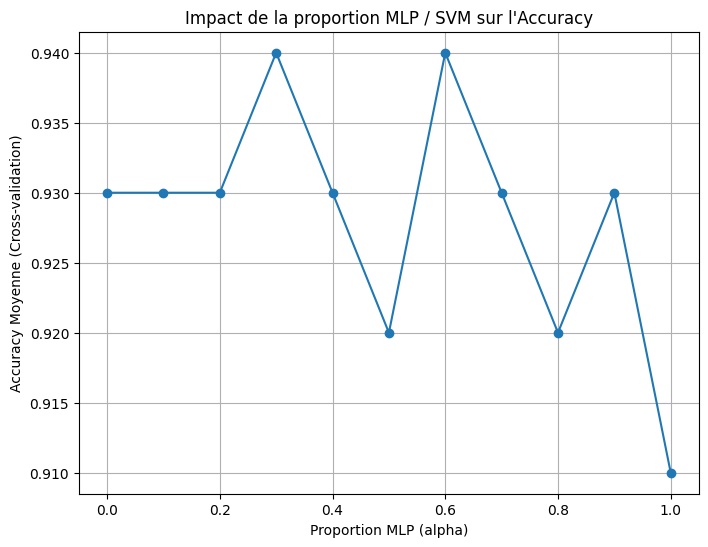

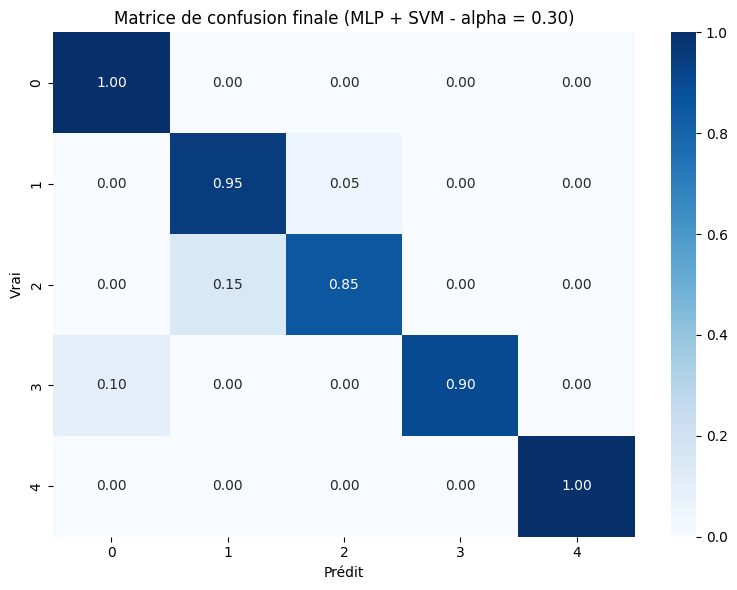


✅ Accuracy finale globale (alpha=0.30) : 0.9400


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Chargement des données
df = pd.read_csv("features.csv")
X = df.drop(columns=["patient_id", "category"]).values
y = df["category"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

n_features = X.shape[1]
n_classes = len(np.unique(y))

# === Définition du MLP
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# === Recherche de la meilleure alpha ===
proportions = np.linspace(0, 1, 11)
results = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for alpha in proportions:
    print(f"\n======= Proportion MLP = {alpha:.2f} =======")
    fold_acc = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
        y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

        # SVM
        svm = SVC(C=10, kernel='linear', gamma='auto', probability=True, random_state=42)
        svm.fit(X_train.numpy(), y_train.numpy())
        svm_probs = svm.predict_proba(X_val.numpy())

        # MLP ensemble
        n_mlps = 50
        batch_size = 30
        n_epochs = 200
        softmax = torch.nn.Softmax(dim=1)

        mlp_probs_ensemble = []

        for _ in range(n_mlps):
            idx_patients = np.random.choice(len(X_train), int(0.75 * len(X_train)), replace=False)
            idx_features = np.sort(np.random.choice(n_features, int(2 * n_features / 3), replace=False))

            X_sub = X_train[idx_patients][:, idx_features]
            y_sub = y_train[idx_patients]

            loader = DataLoader(TensorDataset(X_sub, y_sub), batch_size=batch_size, shuffle=True)

            model = MLP(input_dim=len(idx_features), output_dim=n_classes)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
            criterion = nn.CrossEntropyLoss()

            model.train()
            for _ in range(n_epochs):
                for xb, yb in loader:
                    out = model(xb)
                    loss = criterion(out, yb)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            model.eval()
            with torch.no_grad():
                logits = model(X_val[:, idx_features])
                probs = softmax(logits).cpu().numpy()
                mlp_probs_ensemble.append(probs)

        mlp_probs_ensemble = np.stack(mlp_probs_ensemble, axis=0)
        mlp_probs_mean = mlp_probs_ensemble.mean(axis=0)

        # Fusion
        final_probs = alpha * mlp_probs_mean + (1 - alpha) * svm_probs
        final_preds = np.argmax(final_probs, axis=1)

        acc = accuracy_score(y_val.numpy(), final_preds)
        fold_acc.append(acc)

    avg_acc = np.mean(fold_acc)
    results.append(avg_acc)
    print(f"✅ Accuracy Moyenne pour proportion {alpha:.2f}: {avg_acc:.4f}")

# === Trouver la meilleure alpha
best_alpha_idx = np.argmax(results)
best_alpha = proportions[best_alpha_idx]
print("\n⭐ Meilleure proportion alpha:", best_alpha)

# === Courbe Accuracy / Alpha (sans la ligne rouge)
plt.figure(figsize=(8,6))
plt.plot(proportions, results, marker='o')
plt.xlabel("Proportion MLP (alpha)")
plt.ylabel("Accuracy Moyenne (Cross-validation)")
plt.title("Impact de la proportion MLP / SVM sur l'Accuracy")
plt.grid(True)
plt.show()

# === Matrice de confusion finale avec le meilleur alpha ===

all_preds = []
all_true = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
    y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

    # SVM
    svm = SVC(C=10, kernel='linear', gamma='auto', probability=True, random_state=42)
    svm.fit(X_train.numpy(), y_train.numpy())
    svm_probs = svm.predict_proba(X_val.numpy())

    # MLP ensemble
    n_mlps = 50
    batch_size = 30
    n_epochs = 200
    softmax = torch.nn.Softmax(dim=1)
    mlp_probs_ensemble = []

    for _ in range(n_mlps):
        idx_patients = np.random.choice(len(X_train), int(0.75 * len(X_train)), replace=False)
        idx_features = np.sort(np.random.choice(n_features, int(2 * n_features / 3), replace=False))

        X_sub = X_train[idx_patients][:, idx_features]
        y_sub = y_train[idx_patients]

        loader = DataLoader(TensorDataset(X_sub, y_sub), batch_size=batch_size, shuffle=True)

        model = MLP(input_dim=len(idx_features), output_dim=n_classes)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        model.train()
        for _ in range(n_epochs):
            for xb, yb in loader:
                out = model(xb)
                loss = criterion(out, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        model.eval()
        with torch.no_grad():
            logits = model(X_val[:, idx_features])
            probs = softmax(logits).cpu().numpy()
            mlp_probs_ensemble.append(probs)

    mlp_probs_ensemble = np.stack(mlp_probs_ensemble, axis=0)
    mlp_probs_mean = mlp_probs_ensemble.mean(axis=0)

    # Fusion finale
    final_probs = best_alpha * mlp_probs_mean + (1 - best_alpha) * svm_probs
    final_preds = np.argmax(final_probs, axis=1)

    all_preds.extend(final_preds)
    all_true.extend(y_val.numpy())

# === Matrice de confusion
conf_mat = confusion_matrix(all_true, all_preds)
conf_mat_norm = conf_mat.astype(float) / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
sns.heatmap(conf_mat_norm, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=np.arange(n_classes),
            yticklabels=np.arange(n_classes))
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title(f"Matrice de confusion finale (MLP + SVM - alpha = {best_alpha:.2f})")
plt.tight_layout()
plt.show()

# Accuracy finale globale
accuracy = accuracy_score(all_true, all_preds)
print(f"\n Accuracy finale globale (alpha={best_alpha:.2f}) : {accuracy:.4f}")

# On sauvegarde les modèle pour les appliquer aux données de test.

In [131]:
import joblib

# Sauvegarde du scaler

joblib.dump(model, "mlp_model.pkl")

# Sauvegarde du Random Forest
joblib.dump(rf, "random_forest.pkl")

# Sauvegarde du Random Forest avec moins de paramètres
joblib.dump(rf_selected, "random_forest_selected.pkl")

# Sauvegarde du SVM
joblib.dump(svm, "svm.pkl")

['svm.pkl']

# On charge les données de tete et tous leur features comme pour les donnée d'entraînement

### Pour commencer on doit rajouter le label manquant qui est le ventricule gauche sur les données de test.

In [ ]:
import nibabel as nib
import numpy as np
import os
from scipy.ndimage import binary_fill_holes

# Dossier contenant les dossiers de test (ex: ./data/)
root_dir = "Test"  # À adapter

# Pour chaque patient de 101 à 150
for i in range(101, 151):
    patient_id = f"{i:03}"
    patient_dir = os.path.join(root_dir, patient_id)

    for phase in ["ED", "ES"]:
        filename = f"{patient_id}_{phase}_seg.nii"
        filepath = os.path.join(patient_dir, filename)

        if not os.path.exists(filepath):
            print(f"❌ Fichier manquant : {filepath}")
            continue

        # Charger le masque
        img = nib.load(filepath)
        seg = img.get_fdata()
        new_seg = np.copy(seg)

        # Remplir le trou intérieur du label 2
        for z in range(seg.shape[2]):
            mask_2 = (seg[:, :, z] == 2)
            filled = binary_fill_holes(mask_2)
            hole = filled & (~mask_2)
            new_seg[:, :, z][hole] = 3  # ajouter le label 3

        # Sauvegarder en écrasant le fichier existant
        nib.save(nib.Nifti1Image(new_seg, affine=img.affine), filepath)

        print(f"✅ Fichier corrigé et écrasé : {filepath}")

### On vérifie que le label est bien ajouté.

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Charger le masque
path_to_seg = "Test/110/110_ED_seg.nii"  # Remplace par ton fichier *_seg.nii
seg_img = nib.load(path_to_seg)
seg_data = seg_img.get_fdata()

# Choisir le label à visualiser (ex: 1 pour le ventricule gauche)
label = 3
label_mask = (seg_data == label).astype(np.uint8)

# Vérifier s'il est présent
if np.sum(label_mask) == 0:
    print(f"⚠️ Le label {label} est absent dans cette segmentation.")
else:
    # Afficher une coupe où il est visible
    slice_index = np.argmax(np.sum(label_mask, axis=(0, 1)))  # coupe avec max d'étiquettes
    plt.imshow(label_mask[:, :, slice_index], cmap="gray")
    plt.title(f"Label {label} – Coupe {slice_index}")
    plt.axis("off")
    plt.show()

### On charge maintenant tous les features des données de test

In [132]:
import os
import nibabel as nib
import numpy as np
import pandas as pd

# === Chemins ===
DATA_DIR = "Test"
CSV_PATH = "metaDataTest.csv"
OUTPUT_CSV = "features_test.csv"

# === Fonctions utilitaires ===
def load_mask(path):
    nii = nib.load(path)
    data = nii.get_fdata()
    spacing = nii.header.get_zooms()[:3]
    return data, spacing

def compute_volume(mask, label, spacing):
    voxel_volume = np.prod(spacing)  # mm³
    count = np.sum(mask == label)
    return count * voxel_volume / 1000  # en mL

def compute_mass(mask, spacing):
    volume = compute_volume(mask, label=2, spacing=spacing)
    return volume * 1.05

def compute_ef(ed_vol, es_vol):
    return 100 * (ed_vol - es_vol) / ed_vol if ed_vol else 0

def compute_bsa_mosteller(weight, height):
    return np.sqrt((weight * height) / 3600)

# === Chargement des métadonnées ===
meta_df = pd.read_csv(CSV_PATH)
meta_df["Id"] = meta_df["Id"].apply(lambda x: str(x).zfill(3))
meta_df = meta_df.set_index("Id")

# === Liste des patients ===
patients = [p for p in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, p))]

all_features = []

for pid in sorted(patients):
    print(f"🔍 Processing patient {pid}")
    try:
        prefix = pid

        ed_seg_path = os.path.join(DATA_DIR, pid, f"{prefix}_ED_seg.nii")
        es_seg_path = os.path.join(DATA_DIR, pid, f"{prefix}_ES_seg.nii")

        ed_mask, spacing = load_mask(ed_seg_path)
        es_mask, _ = load_mask(es_seg_path)

        ed_vg = compute_volume(ed_mask, label=3, spacing=spacing)
        es_vg = compute_volume(es_mask, label=3, spacing=spacing)
        ed_rv = compute_volume(ed_mask, label=1, spacing=spacing)
        es_rv = compute_volume(es_mask, label=1, spacing=spacing)

        mass_ed = compute_mass(ed_mask, spacing)
        mass_es = compute_mass(es_mask, spacing)
        mass_avg = (mass_ed + mass_es) / 2

        ef = compute_ef(ed_vg, es_vg)
        rv_ef = compute_ef(ed_rv, es_rv)

        weight = meta_df.loc[pid]["Weight"]
        height = meta_df.loc[pid]["Height"]
        bsa = compute_bsa_mosteller(weight, height)

        stroke_volume = ed_vg - es_vg
        lv_mass_index = mass_avg / bsa
        es_vg_index = es_vg / bsa
        ed_rv_index = ed_rv / bsa
        ratio_rv_vg_es = es_rv / es_vg if es_vg else 0
        ratio_rv_vg_ed = ed_rv / ed_vg if ed_vg else 0

        # Nouveaux biomarqueurs
        ed_vg_index = ed_vg / bsa if bsa else 0
        es_rv_index = es_rv / bsa if bsa else 0
        myocardium_to_vg_ed = mass_ed / ed_vg if ed_vg else 0
        mass_to_edv_ratio = mass_avg / ed_vg if ed_vg else 0
        mass_ratio_systole_diastole = mass_es / mass_ed if mass_ed else 0

        features = {
            "patient_id": pid,
            "ed_vg_vol": ed_vg,
            "es_vg_vol": es_vg,
            "ef": ef,
            "ed_rv_vol": ed_rv,
            "es_rv_vol": es_rv,
            "rv_ef": rv_ef,
            "myocardium_mass": mass_avg,
            "lv_mass_index": lv_mass_index,
            "stroke_volume": stroke_volume,
            "es_vg_index": es_vg_index,
            "ed_rv_index": ed_rv_index,
            "ratio_rv_vg_es": ratio_rv_vg_es,
            "ratio_rv_vg_ed": ratio_rv_vg_ed,
            "weight": weight,
            "height": height,
            "bsa": bsa,
            "ed_vg_index": ed_vg_index,
            "es_rv_index": es_rv_index,
            "myocardium_to_vg_ed": myocardium_to_vg_ed,
            "mass_to_edv_ratio": mass_to_edv_ratio,
            "mass_ratio_systole_diastole": mass_ratio_systole_diastole
        }

        all_features.append(features)

    except Exception as e:
        print(f"❌ Erreur pour {pid} : {e}")

# === Export CSV
df = pd.DataFrame(all_features)
df.to_csv(OUTPUT_CSV, index=False)
print(f"\n✅ Fichier de features enrichi enregistré : {OUTPUT_CSV}")

🔍 Processing patient 101
🔍 Processing patient 102
🔍 Processing patient 103
🔍 Processing patient 104
🔍 Processing patient 105
🔍 Processing patient 106
🔍 Processing patient 107
🔍 Processing patient 108
🔍 Processing patient 109
🔍 Processing patient 110
🔍 Processing patient 111
🔍 Processing patient 112
🔍 Processing patient 113
🔍 Processing patient 114
🔍 Processing patient 115
🔍 Processing patient 116
🔍 Processing patient 117
🔍 Processing patient 118
🔍 Processing patient 119
🔍 Processing patient 120
🔍 Processing patient 121
🔍 Processing patient 122
🔍 Processing patient 123
🔍 Processing patient 124
🔍 Processing patient 125
🔍 Processing patient 126
🔍 Processing patient 127
🔍 Processing patient 128
🔍 Processing patient 129
🔍 Processing patient 130
🔍 Processing patient 131
🔍 Processing patient 132
🔍 Processing patient 133
🔍 Processing patient 134
🔍 Processing patient 135
🔍 Processing patient 136
🔍 Processing patient 137
🔍 Processing patient 138
🔍 Processing patient 139
🔍 Processing patient 140


### Et on applique les prédictions à l'aide des modèles chargés.

In [157]:
import joblib
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd

# === Charger les données de test ===
df_test = pd.read_csv("features_test.csv")
X_test = df_test.drop(columns=["patient_id"]).values

# === Charger les objets sauvegardés ===
mlp_ensemble = joblib.load("mlp_ensemble.pkl")
rf = joblib.load("random_forest.pkl")
rf_selected = joblib.load("random_forest_selected.pkl")
svm = joblib.load("svm.pkl")

# === Normalisation ===
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# === Prédictions MLP ===
n_classes = rf.n_classes_
mlp_probs = np.zeros((len(X_test), n_classes))
softmax = torch.nn.Softmax(dim=1)

for model, features in mlp_ensemble.models_feats:
    model.eval()
    with torch.no_grad():
        logits = model(X_test_tensor[:, features])
        probs = softmax(logits).numpy()
        mlp_probs += probs

mlp_probs /= len(mlp_ensemble.models_feats)

# === Prédictions Random Forest
rf_probs = rf.predict_proba(X_test_scaled)

# === Fusion avec pondération équilibrée
final_probs = 0.5 * mlp_probs + 0.5 * rf_probs
final_preds = np.argmax(final_probs, axis=1)

# === Affichage des résultats
print("✅ Prédictions (sans étiquette fournie) :")
for pid, pred in zip(df_test["patient_id"], final_preds):
    print(f"Patient {pid} → catégorie prédite : {pred}")

✅ Prédictions (sans étiquette fournie) :
Patient 101 → catégorie prédite : 0
Patient 102 → catégorie prédite : 4
Patient 103 → catégorie prédite : 0
Patient 104 → catégorie prédite : 0
Patient 105 → catégorie prédite : 2
Patient 106 → catégorie prédite : 1
Patient 107 → catégorie prédite : 4
Patient 108 → catégorie prédite : 2
Patient 109 → catégorie prédite : 1
Patient 110 → catégorie prédite : 0
Patient 111 → catégorie prédite : 3
Patient 112 → catégorie prédite : 2
Patient 113 → catégorie prédite : 1
Patient 114 → catégorie prédite : 4
Patient 115 → catégorie prédite : 3
Patient 116 → catégorie prédite : 2
Patient 117 → catégorie prédite : 4
Patient 118 → catégorie prédite : 4
Patient 119 → catégorie prédite : 4
Patient 120 → catégorie prédite : 2
Patient 121 → catégorie prédite : 0
Patient 122 → catégorie prédite : 1
Patient 123 → catégorie prédite : 0
Patient 124 → catégorie prédite : 1
Patient 125 → catégorie prédite : 3
Patient 126 → catégorie prédite : 2
Patient 127 → catégorie

# Meileur résultat obtenu sur Kaggle
### Le classifieur qui au final donné le meilleur résultat sur Kaggle est le Random Forest seul suivant :

In [159]:
df = pd.read_csv("features.csv")
patient_ids = df["patient_id"].values
X = df.drop(columns=["patient_id", "category"]).values
y = df["category"].values

# === Shuffle synchronisé
from sklearn.utils import shuffle
X, y, patient_ids = shuffle(X, y, patient_ids, random_state=42)

# Normalisation
scaler = StandardScaler()
X = scaler.fit_transform(X)

#Random forest final
rf_final = RandomForestClassifier(n_estimators=100, random_state=42)
rf_final.fit(X, y)


# Sauvegarde du Random Forest
joblib.dump(rf_final, "random_forest_final.pkl")

# === Charger les données de test ===
df_test = pd.read_csv("features_test.csv")
X_test = df_test.drop(columns=["patient_id"]).values

# === Charger les objets sauvegardés ===
rf_final = joblib.load("random_forest_final.pkl")

# === Normalisation ===
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)


# === Prédictions Random Forest
rf_probs = rf.predict_proba(X_test_scaled)

# === Fusion
final_probs =  rf_probs
final_preds = np.argmax(final_probs, axis=1)


In [160]:
# Si la colonne "patient_id" est présente dans le fichier test :
patient_ids = df_test["patient_id"]

# Crée un fichier de soumission conforme
submission_df = pd.DataFrame({
    "Id": df_test["patient_id"],
    "category": final_preds
})

submission_df.to_csv("submission_fin.csv", index=False)
print("✅ Fichier de soumission généré : submission.csv")

✅ Fichier de soumission généré : submission.csv
